## **W10 G2 Real-time object tracking with KF**

## Agenda

1. Real-time Object tracking Definition

2. When to use and not use Kalman Filters (KF)

3. Real Time Object tracking with KF example

4. Pros, Cons and Summary

## Basic principle

1. Recording object movement
2. Object recognition
3. Object tracking
4. Correction


### Recording movement

- Multiple ways
    - Optical
    - Radar
    - LiDAR
    - Electronic

  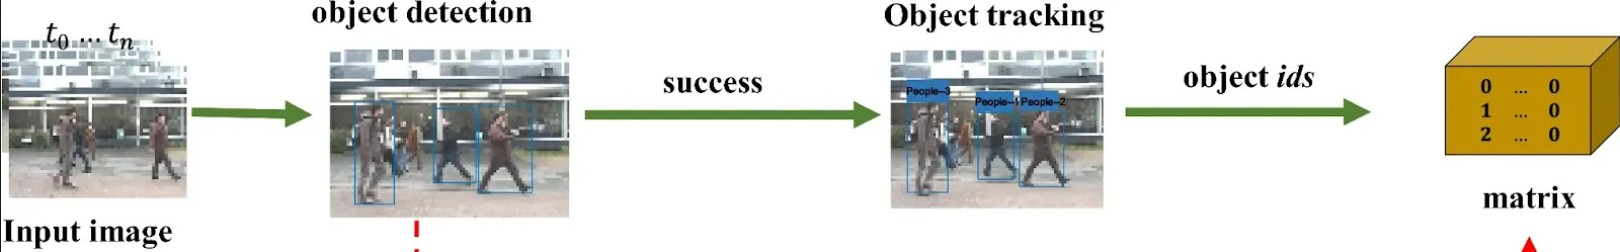

### Object recognition

Some appropriate algorithm

 - Edge tracking
 - Contour tracking
 - ML Models
 - [Wikipedia](https://en.wikipedia.org/wiki/Outline_of_object_recognition)

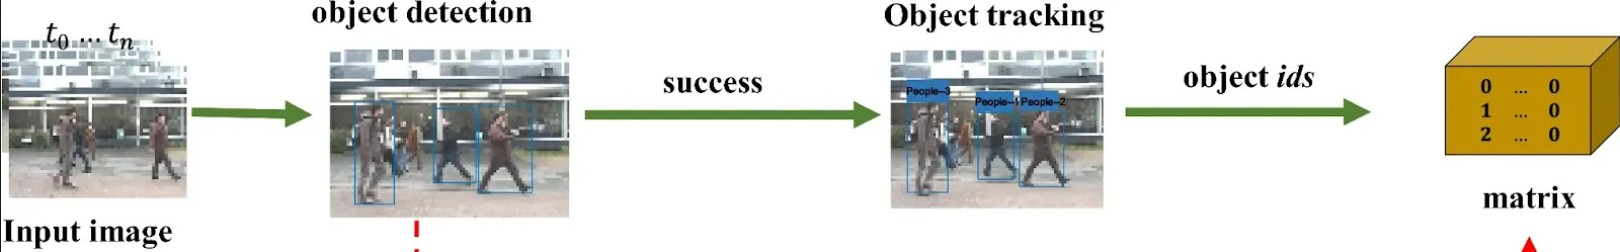

**Outputs positions in "image"**

### Object tracking (Kalman Filter)

Tracks position by predicting the future position.

Used to connect two timesteps or "images"

Can be used to estimate velocity, acceleration, etc.

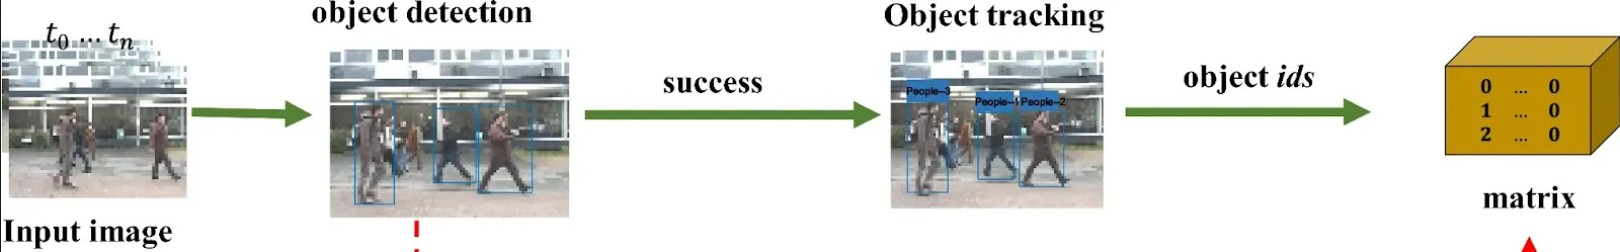

### Correction

Estimates can be used to more effectively track objects

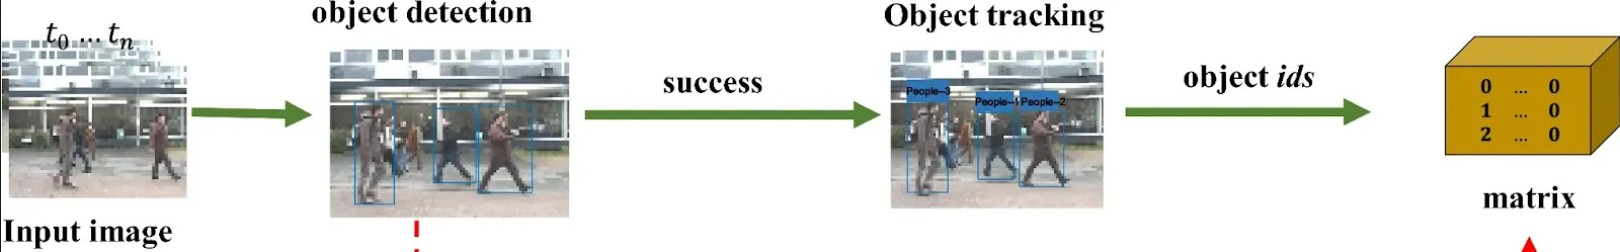



# **2. When to use and not use Kalman Filters (KF)**

The Kalman Filter (KF) is an optimal recursive estimator for linear dynamical systems with Gaussian noise. In object tracking, it functions as a motion model that predicts an object's future state and corrects it with new measurements.

Flow of Kalman Filter Formulas for Object Tracking

**1st State Vector (xₖ) and matrices (WHAT WE TRACK)**

A multivariate representation of the object's properties (e.g., [x, y, width, height, vx, vy] for a bounding box and its velocity).

              xₖ = [x, y, w, h, vx, vy, vw, vh]ᵀ

**Position: x, y | Size: w, h | Velocity: vx, vy, vw, vh**

Key Matrices:

*   F: State Transition Matrix (motion model)
*   P: Covariance Matrix (uncertainty)
*   Q: Process Noise (model imperfection)
*   R: Measurement Noise (sensor error)
*   H: Observation Matrix (state → measurement)

**2nd Prediction Step ( WHERE SHOULD IT BE?)**

The KF uses a state transition model (F) to predict the object's next state and the uncertainty (covariance P) of that prediction.

1. Predict State:

                       x̂ₖ⁻ = F · x̂ₖ₋₁
Projects state forward using motion model

2. Predict Uncertainty:

                  Pₖ⁻ = F · Pₖ₋₁ · Fᵀ + Q
Uncertainty grows due to model imperfection

**3rd. Update Step (Correct with measurement)**

When a new measurement (e.g., from a detector like YOLO) arrives, the KF calculates the Kalman Gain (K) to optimally fuse the prediction with the measurement, producing a refined state estimate.

3. Calculate Kalman Gain:

            Kₖ = Pₖ⁻ · Hᵀ · (H · Pₖ⁻ · Hᵀ + R)⁻¹

Optimal weighting: low noise → trust measurement, high noise → trust prediction

4. Update with Measurement:

               x̂ₖ = x̂ₖ⁻ + Kₖ · (zₖ - H · x̂ₖ⁻)

Fusion: Prediction + Correction

5. Update Uncertainty:

                   Pₖ = (I - Kₖ · H) · Pₖ⁻

Uncertainty decreases after measurement



*reference : R. E. Kalman (1960). "A New Approach to Linear Filtering and Prediction Problems." Journal of Basic Engineering.*



**When use KF**

| Scenario | Reason to Use | Example |
| ------------------------------------- | -------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------- |
| **Predictable Motion**        | The KF excels with linear motion models (e.g., constant velocity).| Tracking vehicles on a highway or pedestrians walking in straight lines.         |
| **Noisy Measurements** | It optimally smooths jittery detections from the object detector.      | Stabilizing bounding boxes from a video feed with low resolution or poor lighting. |
| **Temporary Occlusions**        |  KF can predict an object's position during short periods when it is not detected. | A car briefly passing behind a tree; the KF maintains the track until the car re-emerges.         |
| **Computational Efficiency**        | Its recursive nature makes it extremely fast, ideal for real-time systems. | Deploying on embedded systems or drones with limited processing power.         |


**When do not use KF**

| Scenario | Reason to Use | Example |
| ------------------------------------- | -------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------- |
| **Highly Non-Linear Motion**        | The standard KF assumes linear dynamics. It fails with complex, unpredictable motion.| TNon-Linear Filters (EKF, UKF) for turning vehicles. Recurrent Neural Networks (RNNs) for learning complex motion patterns.         |
| **Non-Gaussian Noise** | KF is optimal only for Gaussian noise. It performs poorly with outlier-prone data.      | Particle Filters, which can model arbitrary noise distributions. |
| **Multi-Object Tracking (MOT)**        |  The standard KF does not solve the data association problem (matching detections to tracks). | KF must be part of a larger framework (see below) that includes association algorithms.         |
| **Object Re-identification**        | The KF is a motion model, not an appearance model. It cannot recognize an object after a long-term occlusion. | Appearance-based metrics (e.g., deep feature embeddings) used in modern trackers like DeepSORT.         |


*reference : Y. Li, et al. (2022). "Deep Learning in Video Multi-Object Tracking: A Survey." Neurocomputing*

# **3. Real Time Object tracking with KF example**

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image

def kalman_example(pred_with_gravity = True,
      dt = 0.1,
      total_steps = 200,
      measure_prob = 0.8,
      gravity = -9.81,
      gif_name = "kalman_combined.gif"):

    # -----------------------------
    # True ball motion (parabolic)
    # -----------------------------
    true_positions = []
    pos = np.array([50.0, 450.0])
    velocity = np.array([35.0, 50.0])
    for step in range(total_steps):
        pos = pos + velocity * dt
        velocity[1] += gravity * dt
        true_positions.append(pos.copy())
    true_positions = np.array(true_positions)

    # -----------------------------
    # Simulated noisy measurements (only once per second)
    # -----------------------------
    measurement_noise_std = 5.0
    measure_interval = int(1.0 / dt)  # dt=0.1 → 10 steps

    measurements = []
    for i in range(total_steps):
        # Allow a measurement only on exact second boundaries
        if i % measure_interval == 0:
            # Still apply probability of obtaining a measurement
            if np.random.rand() < measure_prob:
                meas = true_positions[i] + np.random.randn(2) * measurement_noise_std
                measurements.append(meas)
            else:
                measurements.append(None)
        else:
            measurements.append(None)

    # -----------------------------
    # Kalman Filter setup
    # -----------------------------
    x = np.array([0, 0, 0, 0], dtype=float)
    P = np.eye(4) * 500
    F = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    H = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0]])
    R = np.eye(2) * measurement_noise_std**2
    Q = np.eye(4) * 0.1

    B = np.array([[0],
                  [0.5 * dt**2],
                  [0],
                  [dt]])
    u = np.array([gravity])

    pred_positions = []
    state_history = []

    for i in range(total_steps):
        z = measurements[i]

        # --------- Prediction (always) ---------
        if pred_with_gravity:
            x = F @ x + B @ u
            P = F @ P @ F.T + Q
        else:
            x = F @ x
            P = F @ P @ F.T + Q

        pred_positions.append(x[:2].copy())
        state_history.append(x.copy())

        # --------- Update (only when z is valid) ---------
        if z is not None:
            y = z - (H @ x)
            S = H @ P @ H.T + R
            K = P @ H.T @ np.linalg.inv(S)
            x = x + K @ y
            P = (np.eye(4) - K @ H) @ P

    pred_positions = np.array(pred_positions)
    state_history = np.array(state_history)

    # Compute velocities
    true_velocities = np.diff(true_positions, axis=0) / dt
    true_velocities = np.vstack([true_velocities, true_velocities[-1]])
    time = np.arange(total_steps) * dt

    # -----------------------------
    # Measurement timing (once per second)
    # -----------------------------
    measure_interval = int(1.0 / dt)  # dt=0.1 → 10 steps
    measurement_times = np.array([
        (m is not None) and (i % measure_interval == 0)
        for i, m in enumerate(measurements)
    ])

    # -----------------------------
    # Create animated figure
    # -----------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    def init():
        ax1.set_xlim(np.min(true_positions[:,0])-50, np.max(true_positions[:,0])+50)
        ax1.set_ylim(np.min(true_positions[:,1])-50, np.max(true_positions[:,1])+50)
        ax1.set_title("Object motion")
        ax1.set_xlabel("x")
        ax1.set_ylabel("y")

        ax2.set_xlim(0, time[-1])
        ax2.set_ylim(
            min(np.min(state_history), np.min(true_positions), np.min(true_velocities)) - 1,
            max(np.max(state_history), np.max(true_positions), np.max(true_velocities)) + 1
        )
        ax2.set_title("Kalman Filter State Estimates vs True States")
        ax2.set_xlabel("Time [s]")
        ax2.set_ylabel("State values")
        ax2.grid(True)
        return []

    # Plot lines
    line_est_traj, = ax1.plot([], [], 'r-', label='Kalman')
    line_true_traj, = ax1.plot([], [], 'b--', label='True')

    # Measurement scatter (shown once per second)
    meas_scatter = ax1.scatter([], [], s=50, c='k', label='Measurement')

    ax1.legend()

    line_x_kal, = ax2.plot([], [], 'r-', label='x (Kalman)')
    line_x_true, = ax2.plot([], [], 'r--', label='x (True)')
    line_y_kal, = ax2.plot([], [], 'g-', label='y (Kalman)')
    line_y_true, = ax2.plot([], [], 'g--', label='y (True)')
    line_vx_kal, = ax2.plot([], [], 'c-', label='vx (Kalman)')
    line_vx_true, = ax2.plot([], [], 'c--', label='vx (True)')
    line_vy_kal, = ax2.plot([], [], 'm-', label='vy (Kalman)')
    line_vy_true, = ax2.plot([], [], 'm--', label='vy (True)')
    ax2.legend()

    # -----------------------------
    # Update function
    # -----------------------------
    def update(frame):
        # Clamp frame so we never index past total_steps-1
        f = min(frame, total_steps - 1)

        # ------------------------------
        # Trajectories
        # ------------------------------
        line_true_traj.set_data(true_positions[:f+1, 0],
                                true_positions[:f+1, 1])
        line_est_traj.set_data(state_history[:f+1, 0],
                            state_history[:f+1, 1])

        # ------------------------------
        # Measurement dots (once/sec)
        # ------------------------------
        meas_idx = np.where(measurement_times[:f+1])[0]
        if len(meas_idx) > 0:
            meas_scatter.set_offsets(true_positions[meas_idx])
        else:
            meas_scatter.set_offsets([])

        # ------------------------------
        # State plots
        # ------------------------------
        t = time[:f+1]

        line_x_kal.set_data(t, state_history[:f+1, 0])
        line_x_true.set_data(t, true_positions[:f+1, 0])

        line_y_kal.set_data(t, state_history[:f+1, 1])
        line_y_true.set_data(t, true_positions[:f+1, 1])

        line_vx_kal.set_data(t, state_history[:f+1, 2])
        line_vx_true.set_data(t, true_velocities[:f+1, 0])

        line_vy_kal.set_data(t, state_history[:f+1, 3])
        line_vy_true.set_data(t, true_velocities[:f+1, 1])

        return [
            line_true_traj, line_est_traj, meas_scatter,
            line_x_kal, line_x_true, line_y_kal, line_y_true,
            line_vx_kal, line_vx_true, line_vy_kal, line_vy_true
        ]

    ani = animation.FuncAnimation(fig, update, frames=total_steps,
                                  init_func=init, blit=True)

    ani.save(gif_name, writer='pillow', fps=20)
    plt.close(fig)

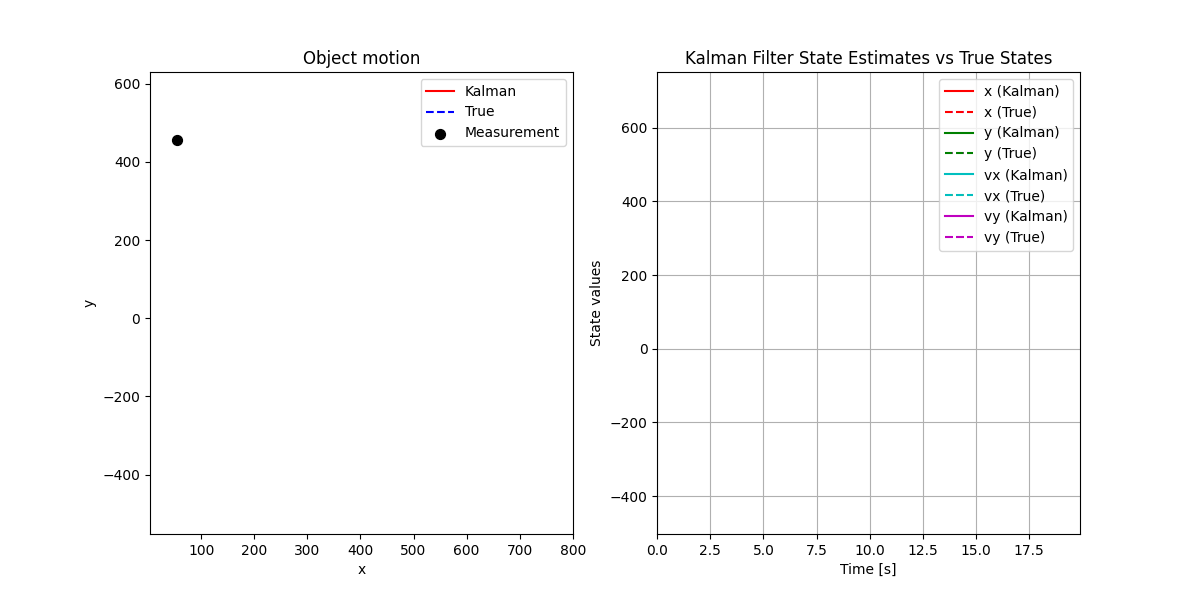

In [ ]:
from IPython.display import Image as IPImage

gif_name = "kalman_no_grav.gif"

kalman_example(pred_with_gravity = False, gif_name = gif_name, measure_prob = 1.0)
IPImage(filename=gif_name)

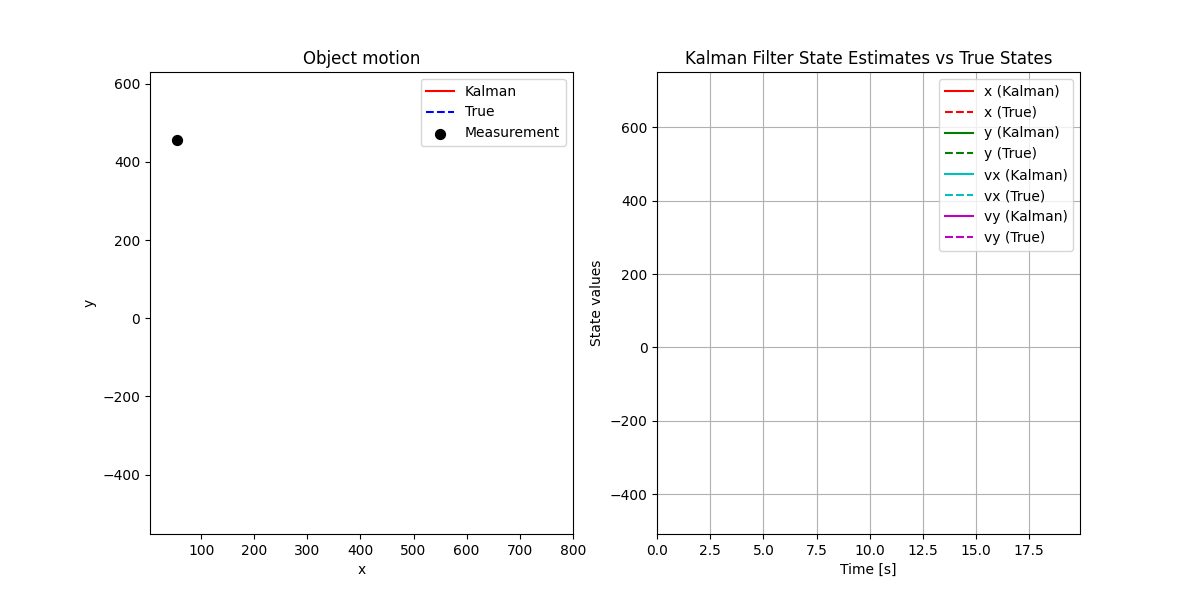

In [ ]:
gif_name = "kalman_with_grav.gif"
kalman_example(pred_with_gravity = True, gif_name = gif_name, measure_prob = 1.0)
IPImage(filename=gif_name)

### **Pros**

**• Real-time efficiency**  
Fast and recursive — ideal for embedded or drone systems.

**• Smooth tracking**  
Filters noise and stabilizes detections.

**• Predictive ability**  
Tracks objects during short occlusions.

**• Easy integration**  
Works well with detectors like YOLO or OpenCV.

###  **Cons**

**• Linear motion only**  
Fails with sharp turns or irregular paths.

**• Gaussian noise required**  
Outliers or non-Gaussian data reduce accuracy.

**• Single-object focus**  
Needs data association for multi-target tracking (e.g., DeepSORT).

**• No visual ID**  
Can’t re-identify after long occlusions.

### **Summary**

Kalman Filter = **Fast, Stable, and Interpretable**  
Best for **predictable linear motion** with **noisy sensors**.

Forms the core of:
- **SORT** (motion-only tracking)
- **DeepSORT** (adds appearance features)

For complex motion → use **EKF, UKF, or Particle Filters**.  
For visual identity → combine with **deep learning models**.